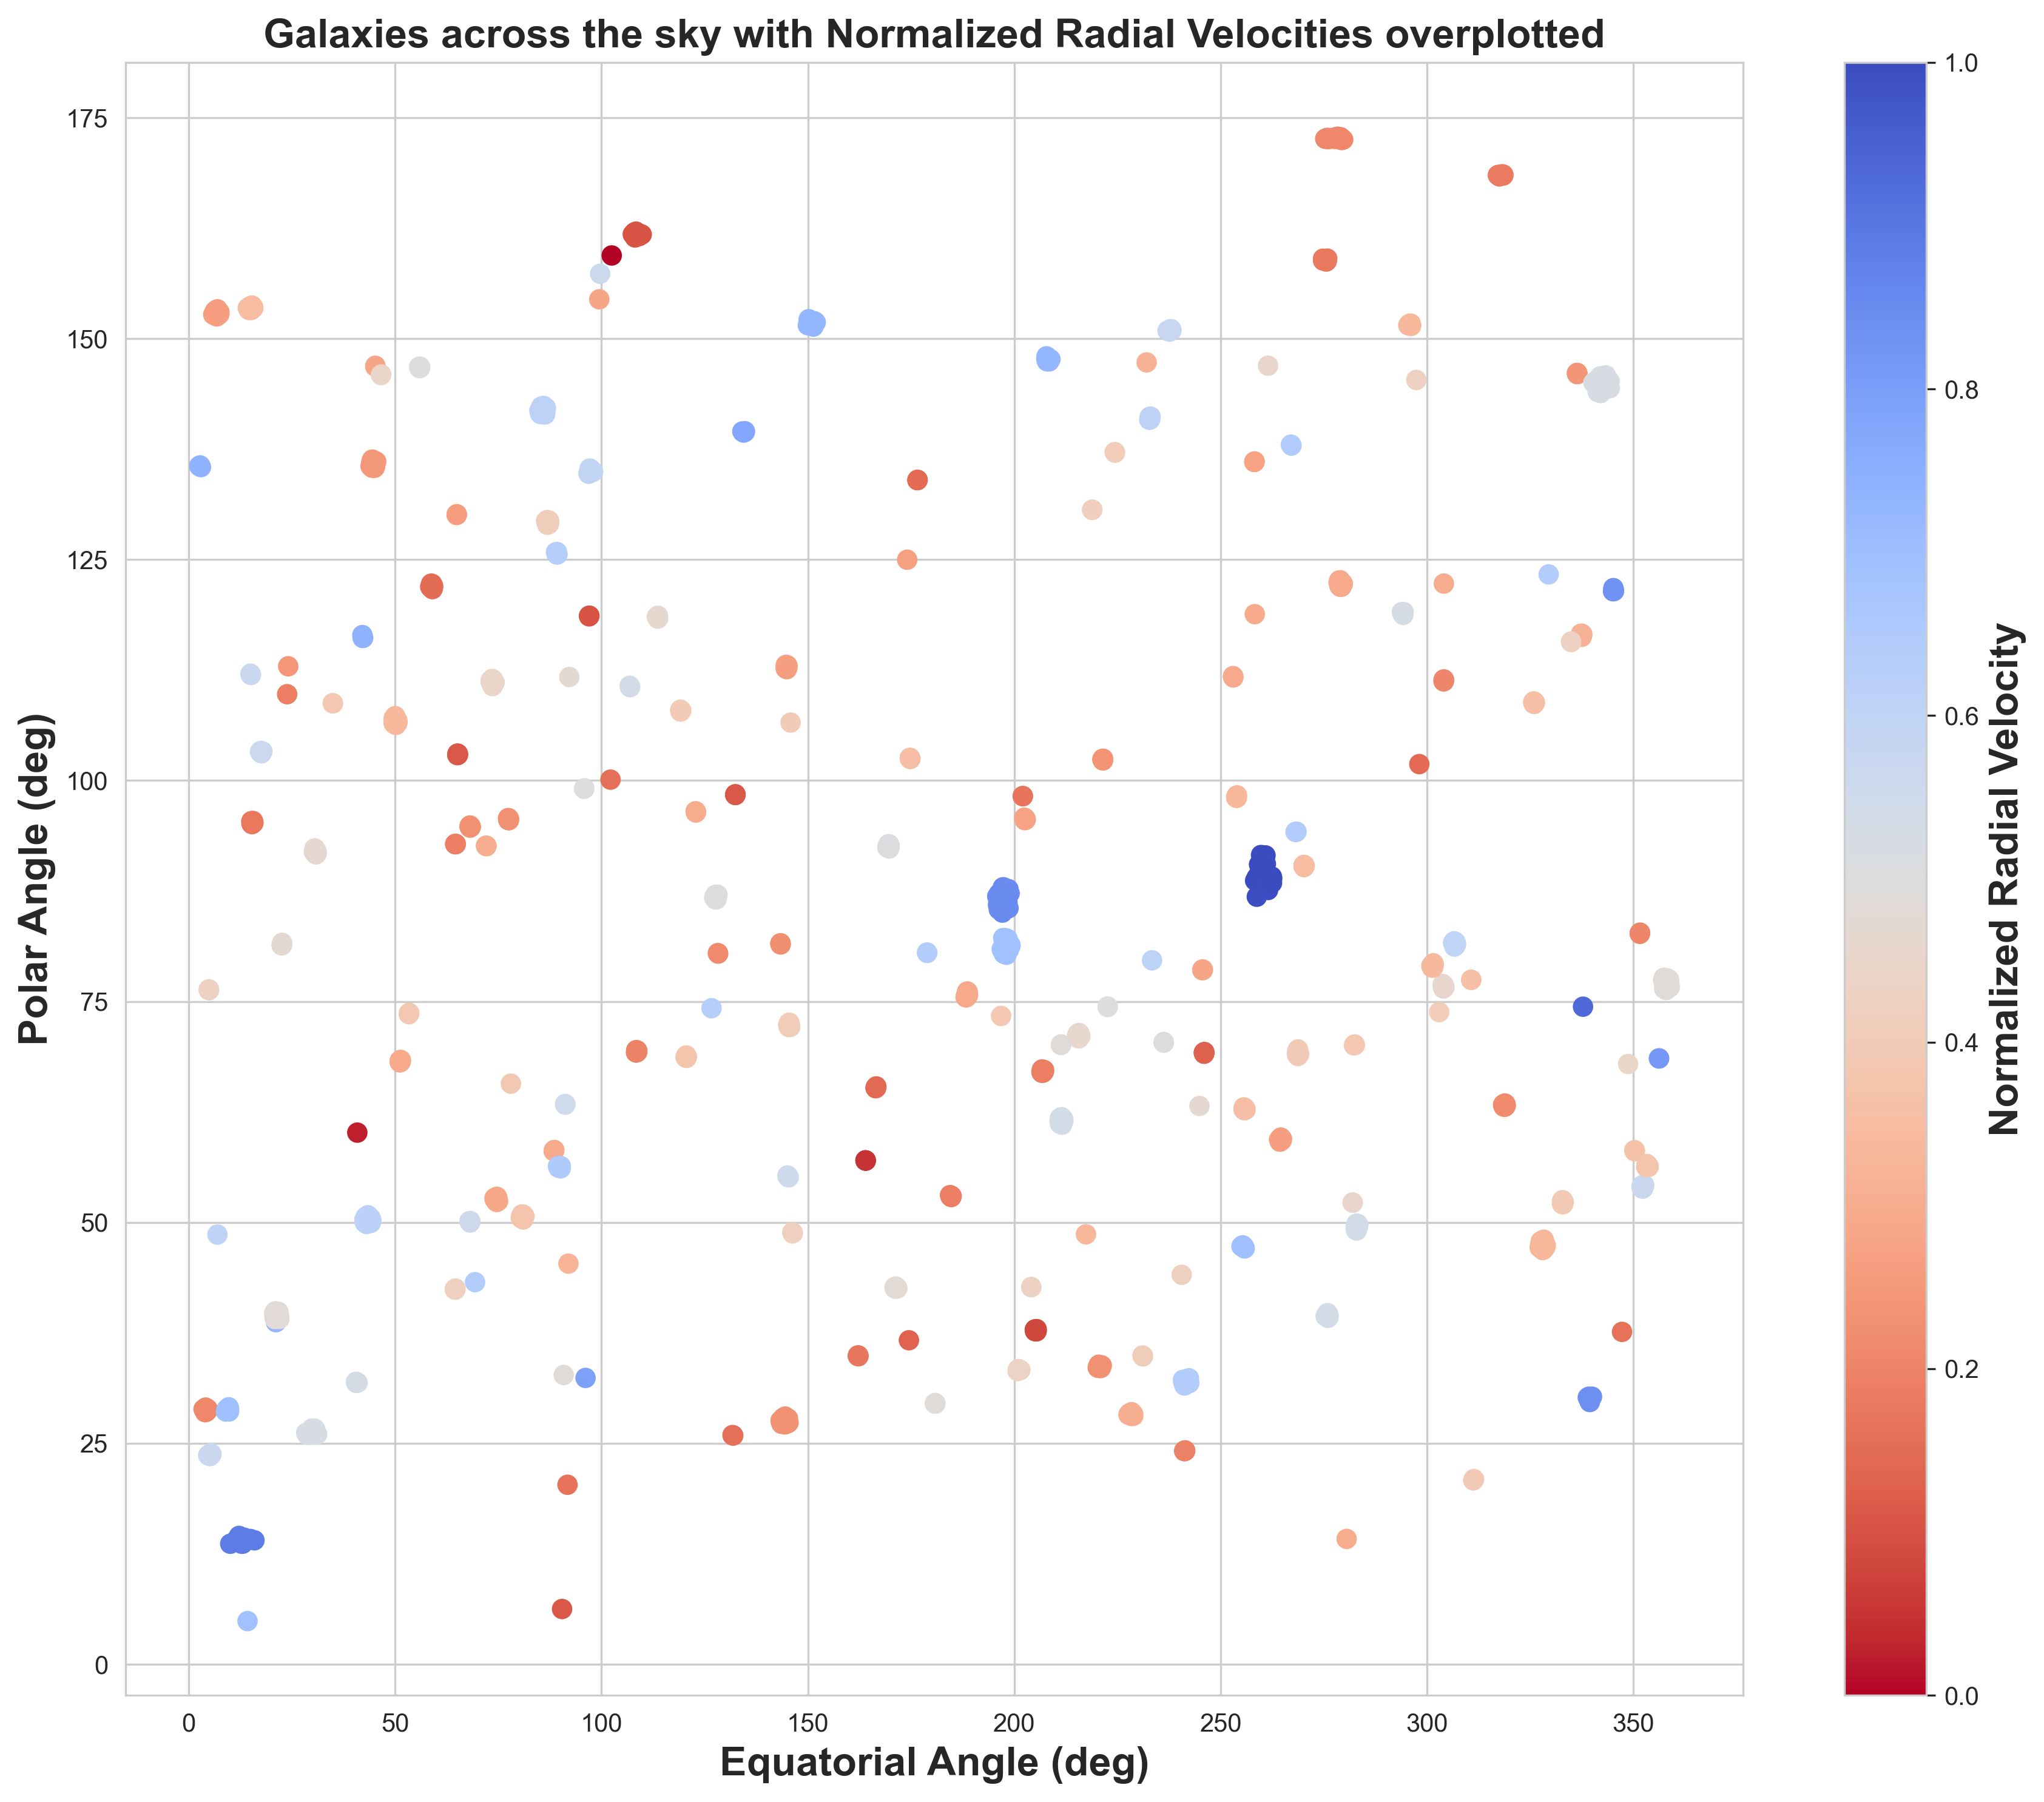

In [12]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the csv file
df = pd.read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Clustered_Distant_Galaxy_Data.csv')

# Normalize radial velocities using Min-Max normalization
min_radial_velocity = df['RadialVelocity'].min()
max_radial_velocity = df['RadialVelocity'].max()
df['NormalizedRadialVelocity'] = (df['RadialVelocity'] - min_radial_velocity) / (max_radial_velocity - min_radial_velocity)

# Galaxy radial velocity visualization
plt.figure(figsize=(12, 10), dpi=300)
scatter = plt.scatter(data=df, x='Equat', y='Polar', c='NormalizedRadialVelocity', cmap='coolwarm_r', s=50, alpha=1)

# Add colorbarCluster_Properties
cbar = plt.colorbar(scatter)
cbar.set_label('Normalized Radial Velocity', fontsize=16, fontweight='bold')

plt.xlabel('Equatorial Angle (deg)', fontsize=16, fontweight='bold')
plt.ylabel('Polar Angle (deg)', fontsize=16, fontweight='bold')
plt.title('Galaxies across the sky with Normalized Radial Velocities overplotted', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()


Number of clusters: 6


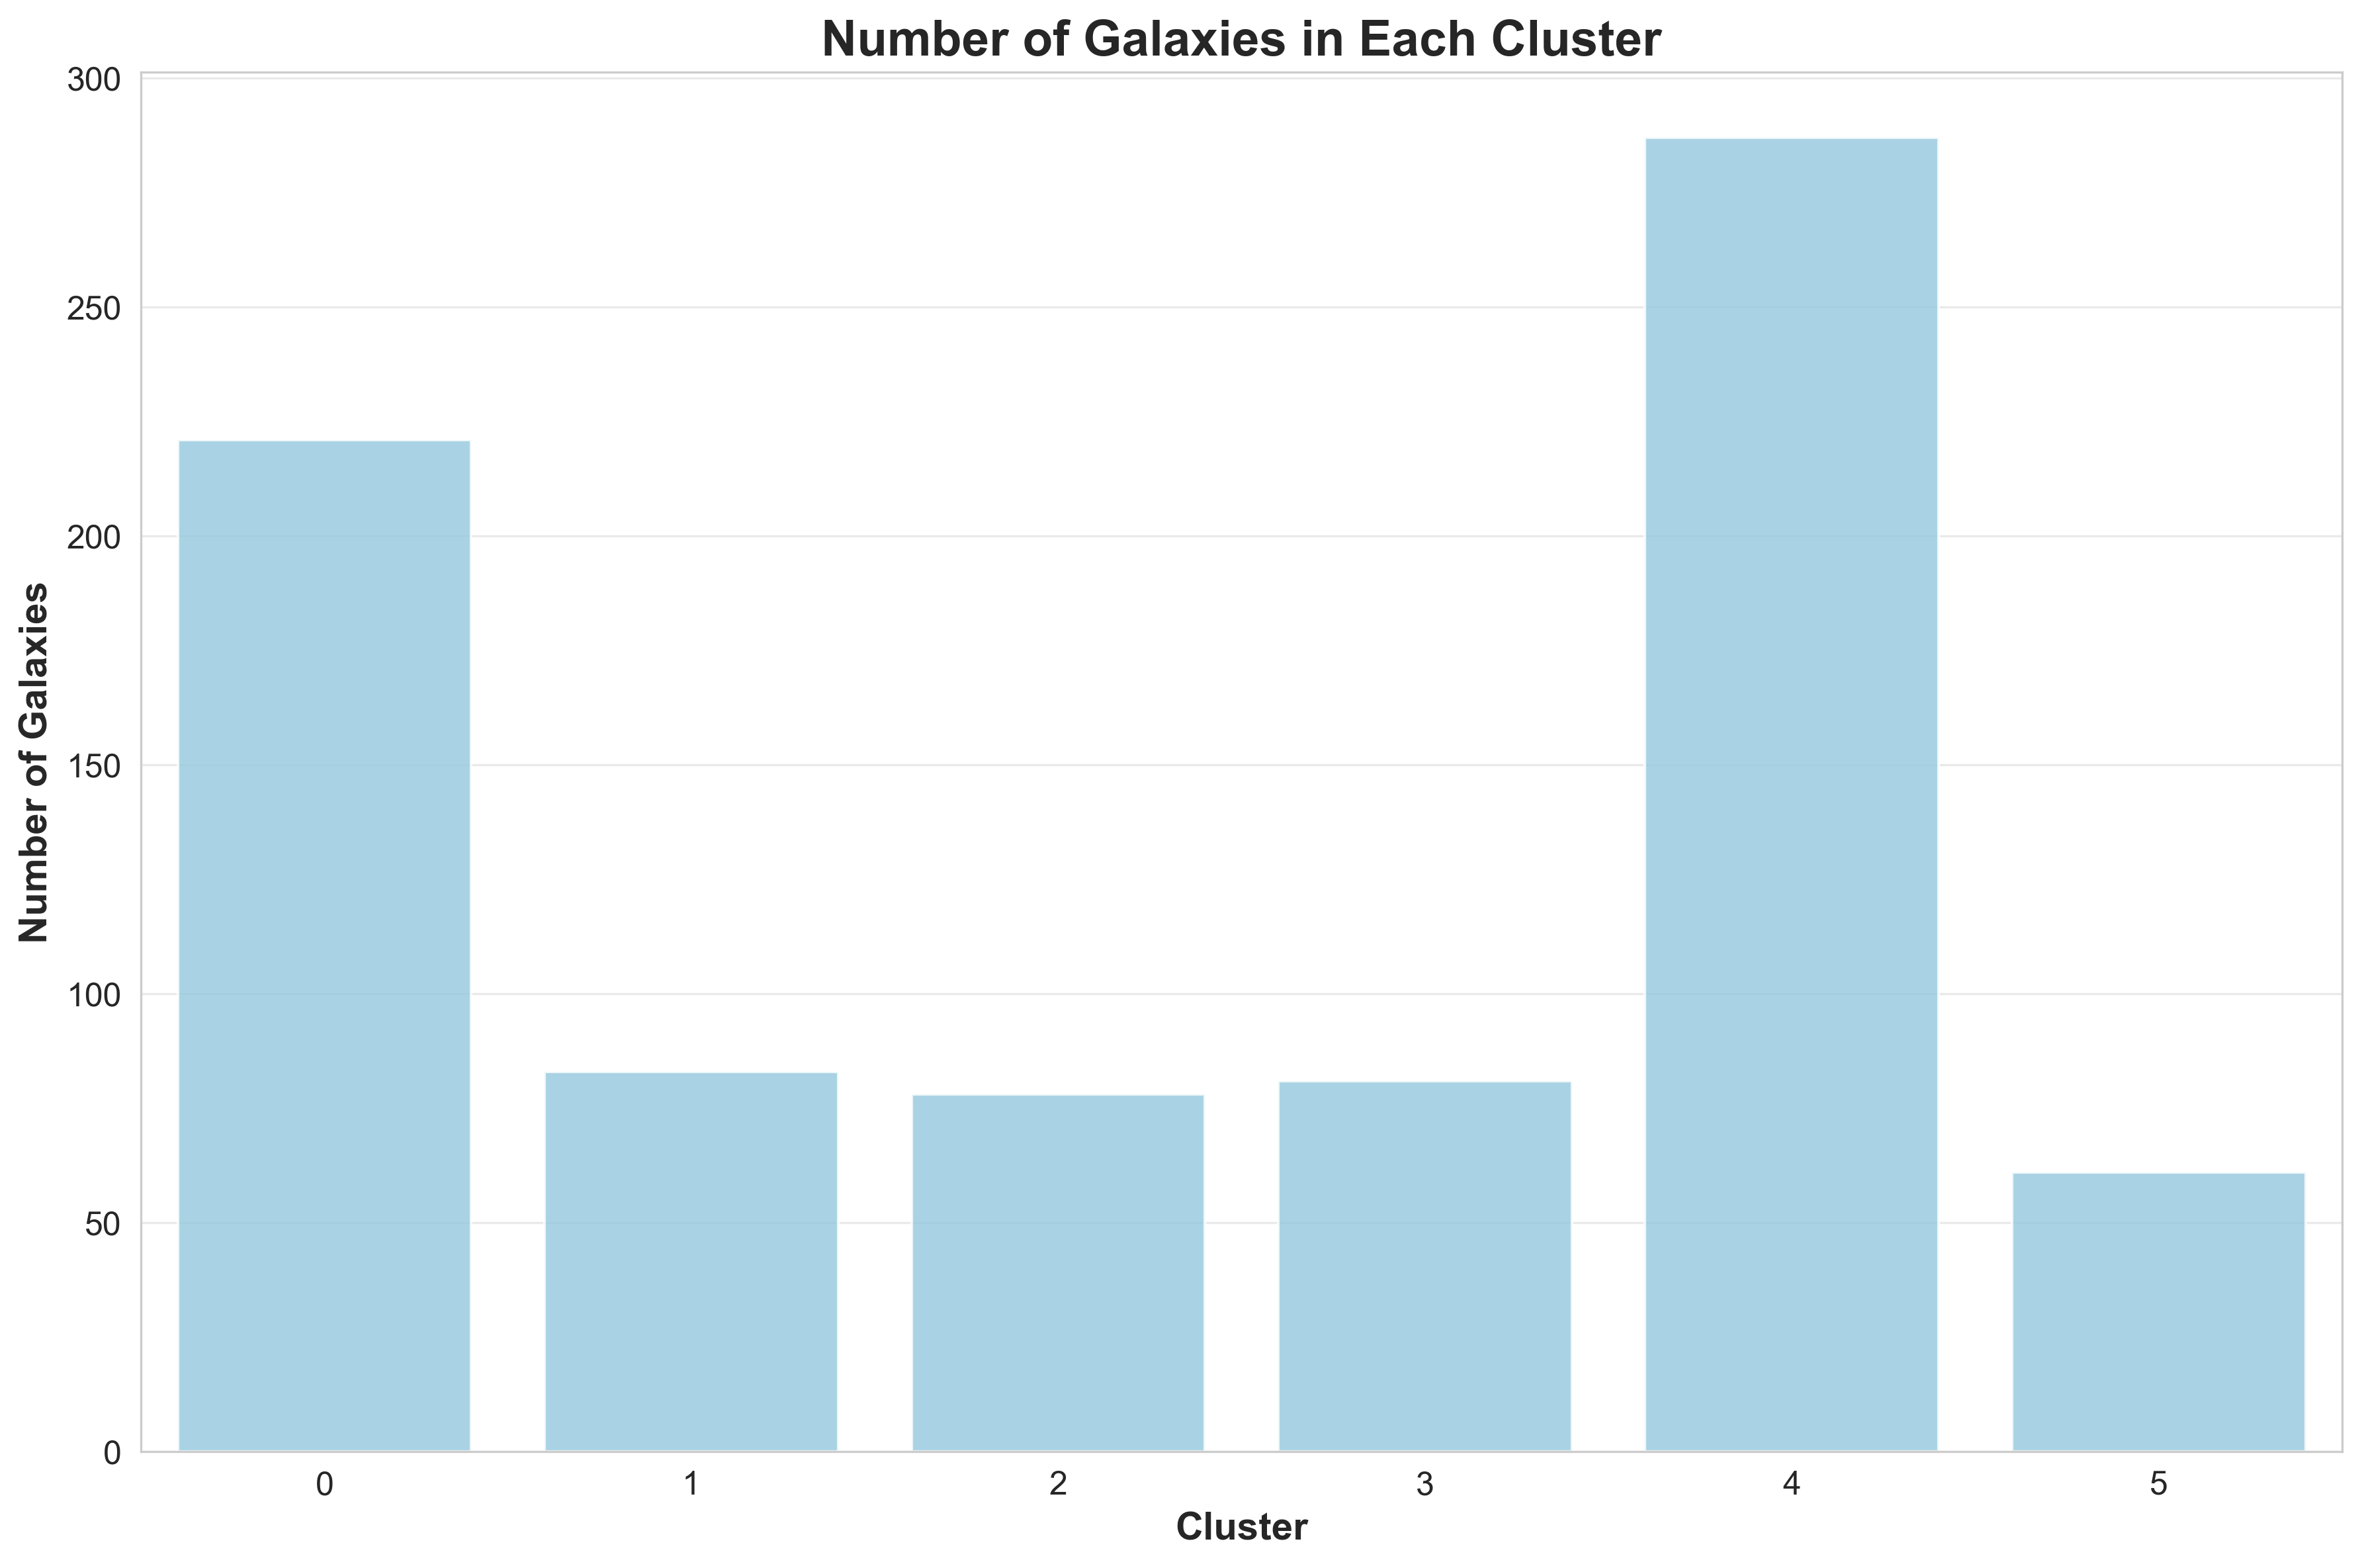

In [37]:
# Filter out noise points (-1 label)
df_clusters = df[df['cluster'] != -1]

# Number of clusters and their sizes
num_clusters = len(df_clusters['cluster'].unique())
print(f'Number of clusters: {num_clusters}')
cluster_sizes = df_clusters['cluster'].value_counts().sort_index()

# Plot the data
plt.figure(figsize=(12, 8), dpi=300)
sns.set_style('whitegrid')
ax = sns.barplot(x=cluster_sizes.index, y=cluster_sizes, color='skyblue', alpha=0.8)

# Set title and axis labels
ax.set_title('Number of Galaxies in Each Cluster', fontsize=18, fontweight='bold')
ax.set_xlabel('Cluster', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of Galaxies', fontsize=14, fontweight='bold')

# Set tick parameters
ax.tick_params(axis='both', which='major', labelsize=12)

# Add grid lines
ax.grid(axis='y', alpha=0.4)

# Save and show the plot
plt.tight_layout()
plt.savefig('galaxy_count_per_cluster.png')
plt.show()


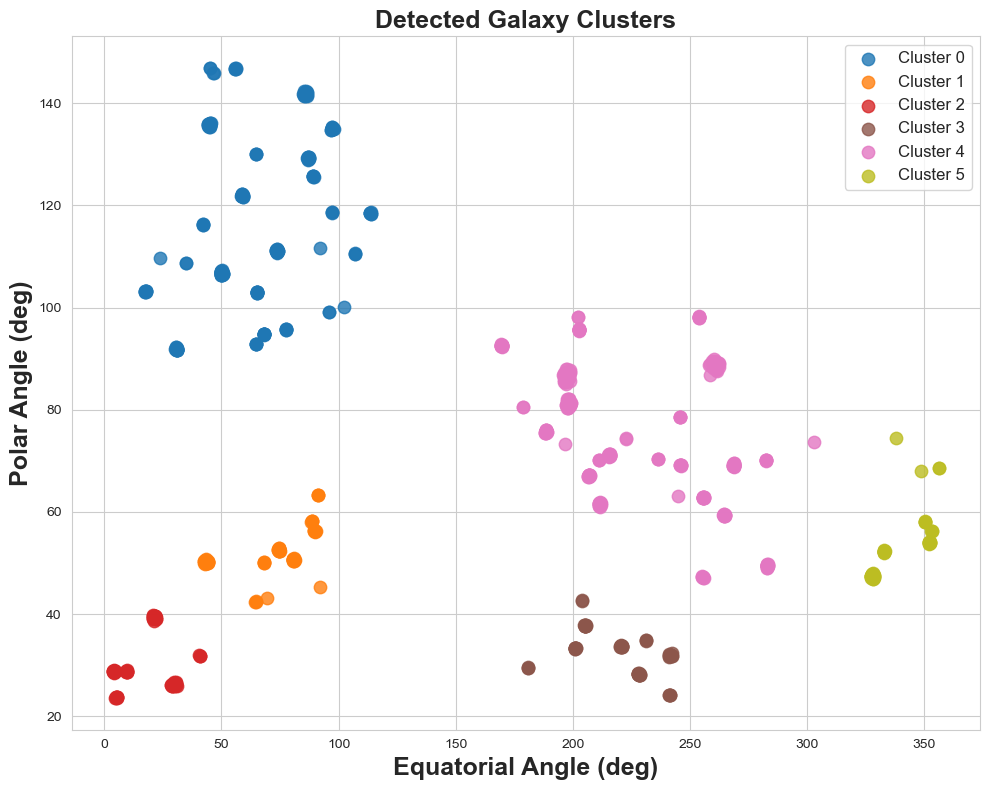

In [31]:
# Plot
plt.figure(figsize=(10, 8))
cmap = plt.cm.get_cmap('tab10', len(df['cluster'].unique()))

# Add points for each cluster
legend_elements = []

for cluster in sorted(cluster for cluster in df['cluster'].unique() if cluster != -1):
    if cluster == -1:
        color = 'blue'
    else:
        color = cmap(cluster)

    scatter_points = plt.scatter(df.loc[df['cluster'] == cluster, 'Equat'], df.loc[df['cluster'] == cluster, 'Polar'],
                                 color=color, alpha=0.8, s=80, zorder=1)
    
    if cluster != -1:
        legend_elements.append(scatter_points)

# Add axis labels and title
plt.xlabel('Equatorial Angle (deg)', fontsize=18, fontweight='bold')
plt.ylabel('Polar Angle (deg)', fontsize=18, fontweight='bold')
plt.title('Detected Galaxy Clusters', fontsize=18, fontweight='bold')

# Create normal legend
cluster_labels = [f'Cluster {i}' for i in sorted(df['cluster'].unique()) if i != -1]
plt.legend(legend_elements, cluster_labels, fontsize='large', loc='upper right')

plt.tight_layout()
plt.savefig('galaxy_clusters.png', dpi=300)
plt.show()


In [21]:
import numpy as np

# Define the Hubble's relation function
def hubble_relation(radial_velocity, uncertainty_radial_velocity):
    hubble_constant = -4784
    hubble_constant_error = 87
    zp_offset = 13.05
    zp_offset_error = 23.25

    # Calculate the distance
    distance = (radial_velocity - zp_offset) / hubble_constant
    distance_error_term1 = (uncertainty_radial_velocity / hubble_constant) ** 2
    distance_error_term2 = ((radial_velocity - zp_offset) * hubble_constant_error / hubble_constant ** 2) ** 2
    distance_error_term3 = (zp_offset_error / hubble_constant) ** 2
    

    # Calculate the uncertainty in the distance
    distance_error = np.sqrt(distance_error_term1 + distance_error_term2 + distance_error_term3)

    return distance, distance_error


# Calculate distances and uncertainties for each galaxy
radial_velocity_uncertainty = 0.1
distances, distance_errors = hubble_relation(df['RadialVelocity'], radial_velocity_uncertainty)

distances = distances * 1_000_000
distance_errors = distance_errors*1_000_000

# Add the distance and uncertainty columns to the DataFrame
df['Distance'] = distances
df['DistanceError'] = distance_errors

# Export the updated DataFrame to a new CSV file
df.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Clustered_Distant_Galaxies_With_Distances.csv', index=False)


In [27]:
from itertools import combinations
from scipy.spatial.distance import pdist, squareform

def angular_separation(cluster_data):
    # Calculate the angular separation between all pairs of galaxies in the cluster
    coordinates = cluster_data[['Equat', 'Polar']].values
    angular_separations = pdist(coordinates, metric='euclidean')
    angular_separation_matrix = squareform(angular_separations)
    

    # Find the maximum angular separation for each galaxy
    max_separations = np.max(angular_separation_matrix, axis=1)

    # Add a new column 'AngularSeparation' to the cluster_data DataFrame
    cluster_data.loc[:, 'AngularSeparation'] = max_separations
    
    return cluster_data

def cluster_radius(cluster_data):
    max_separation = cluster_data['AngularSeparation'].max()
    angular_radius = max_separation / 2
    return angular_radius

def velocity_dispersion(cluster_data):
    max_velocity = cluster_data['RadialVelocity'].max()
    min_velocity = cluster_data['RadialVelocity'].min()
    velocity_dispersion = (max_velocity - min_velocity) * 3
    return velocity_dispersion


def virial_mass(cluster_data, angular_radius, velocity_dispersion, return_uncertainty=False):
    G = 6.67430e-11  
    solar_mass = 1.9885e30  
    radius = (cluster_data['Distance'].mean() * 1e6 * 3.086e+16) * np.tan(np.radians(angular_radius))  
    mass = (radius * (velocity_dispersion * 1000)**2) / (2 * G)  
    
    if not return_uncertainty:
        return mass / solar_mass  

    # Calculate uncertainties
    flux_uncertainty = 0.01
    position_uncertainty = 0.0001
    size_uncertainty = 0.1
    radial_velocity_uncertainty = 0.1

    mass_error_term1 = (2 * flux_uncertainty) ** 2
    mass_error_term2 = (position_uncertainty / angular_radius) ** 2
    mass_error_term3 = (size_uncertainty) ** 2
    mass_error_term4 = (2 * radial_velocity_uncertainty / velocity_dispersion) ** 2

    mass_uncertainty = mass * np.sqrt(mass_error_term1 + mass_error_term2 + mass_error_term3 + mass_error_term4)
    
    return mass, mass_uncertainty

# Calculate the virial mass and uncertainty for each cluster
clusters = []
masses = []
mass_uncertainties = []
angular_radii = []

for cluster_label in df['cluster'].unique():
    if cluster_label == -1:
        continue

    cluster_data = df[df['cluster'] == cluster_label]
    cluster_data = angular_separation(cluster_data)

    angular_radius = cluster_radius(cluster_data)
    vel_dispersion = velocity_dispersion(cluster_data)

    mass, mass_uncertainty = virial_mass(cluster_data, angular_radius, vel_dispersion, return_uncertainty=True)

    clusters.append(cluster_label)
    masses.append(mass)
    mass_uncertainties.append(mass_uncertainty)
    angular_radii.append(angular_radius)

# Create a new DataFrame and export to a CSV file
cluster_mass_data = pd.DataFrame({"cluster": clusters, "mass": masses, "mass_uncertainty": mass_uncertainties, "angular_radius": angular_radii})
cluster_mass_data.to_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Galaxy_Cluster_Masses.csv', index=False)


/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_19127/1675368397.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.loc[:, 'AngularSeparation'] = max_separations
/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_19127/1675368397.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cluster_data.loc[:, 'AngularSeparation'] = max_separations
/var/folders/kv/ny8sb_xj09b1r7l0mtvkgjlm0000gn/T/ipykernel_19127/1675368397.py:15: SettingWithCopyWarning: 
A value is trying to be set 

In [38]:
import pandas as pd

df = pd.read_csv('/Users/kobibrown/Desktop/Distance_Ladder_Project/Converted_Distant_Galaxy_Data.csv')
num_galaxies = len(df)

print("Number of galaxies in the dataset:", num_galaxies)


Number of galaxies in the dataset: 1525
